In [1]:
import cv2
import math
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt

In [2]:
def remove_repeated(points):
    prev = None
    new_list = []
    
    for point in points:
        if prev != point:
            new_list.append(point)
        prev = point
            
    return new_list

In [3]:
def load_data(names):
    points, ranges = [], []
    for dataset in names:
        with open(f"./pooldata/{dataset}_points.json", "r") as f:
            points.append(eval(f.read()))
        with open(f"./pooldata/{dataset}_ranges.json", "r") as f:
            ranges.append(eval(f.read()))
    return points, ranges

In [4]:
def show_data(points, ranges, names):
    fig, axs = plt.subplots(2, 2)
    for i in range(len(points)):
        print(names[i], ranges[i])
        xs = [d[0] for d in points[i]]
        ys = [d[1] for d in points[i]]
        axs[i // 2, i % 2].scatter(xs, ys, s=0.1)
        axs[i // 2, i % 2].set_title(names[i])

betademo [['line', 0, 7200]]
arrowspa [['curve', 0, 3840]]
seagrit [['line', 0, 200], ['curve', 201, 2721], ['line', 2722, 3922], ['curve', 3923, 6923]]
shamrock [['line', 0, 1000], ['curve', 1001, 14201]]


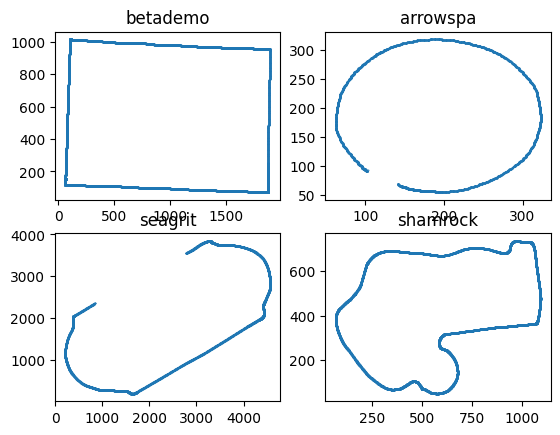

In [5]:
names = ["betademo", "arrowspa", "seagrit", "shamrock"]
data, ranges = load_data(names)
show_data(data, ranges, names)

In [19]:
class Shape(Enum):
    AMBIG = 0
    CIRCLE = 1
    SQUARE = 2


class PointSorter():
    def __init__(self, points):
        self.points = points
    
    def find_borders(self, points):
        contour = np.array(points, dtype=np.float32)
        perim = cv2.arcLength(contour, closed=True)
        borders = cv2.approxPolyDP(curve=contour, epsilon=0.05 * perim, closed=True).squeeze()
        dist = np.ndarray((len(borders), len(points)))
        for i in range(len(borders)):
            for j in range(len(points)):
                dist[i, j] = math.dist(borders[i], points[j])
        border_index = dist.argmin(axis=1)
        border_index.sort()
        return border_index

    def reorder_points(self, points, borders):
        new_points = []
        for i in range(len(borders)):
            if i == len(borders) - 1:
                new_points += points[borders[i]:]
                new_points += points[:borders[0]]
            else:
                new_points += points[borders[i]:borders[i+1]]
        return new_points

    def reorder_points_and_get_borders(self):
        borders = self.find_borders(self.points)
        new_points = self.reorder_points(self.points, borders)
        borders = self.find_borders(new_points)
        return new_points, borders
    
    def visualize_data(self, points, borders):
        for i in range(len(borders)):
            if i == 0:
                xs = [d[0] for d in points[:borders[i]]]
                ys = [d[1] for d in points[:borders[i]]]
                plt.scatter(xs, ys, s=0.02)
            if i == len(borders) - 1:
                xs = [d[0] for d in points[borders[i]:]]
                ys = [d[1] for d in points[borders[i]:]]
                plt.scatter(xs, ys, s=0.02)
            else:
                xs = [d[0] for d in points[borders[i]:borders[i+1]]]
                ys = [d[1] for d in points[borders[i]:borders[i+1]]]
                plt.scatter(xs, ys, s=0.02)
        xs = [points[ind][0] for ind in borders]
        ys = [points[ind][1] for ind in borders]
        plt.scatter(xs, ys, color=(1, 0, 0))


class ShapeTester:
    def __init__(self, points, interp_type, scale):
        self.scale = scale
        self.points = points
        self.interp_type = interp_type

    # Circle
    def normalize_dataset(self, points, scale=1.0):
        xs = [p[0] for p in points]
        ys = [p[1] for p in points]
        minx, miny = min(xs), min(ys)
        translated_points = [[x - minx, y - miny] for x, y in points]
        maxP = max([val for point in translated_points for val in point])
        scaled_points = [[x * scale / maxP, y * scale / maxP]
                         for x, y in translated_points]
        return scaled_points

    def get_circle(self, points):
        contour = np.array(points, dtype=np.float32)
        (cx, cy), cr = cv2.minEnclosingCircle(contour)
        return (cx, cy), cr

    def get_circle_score(self):
        scaled = self.normalize_dataset(self.points)
        circle = self.get_circle(scaled)
        (cx, cy), cr = circle
        total_diff = 0
        for point in scaled:
            total_diff += abs(math.dist(point, (cx, cy)) - cr)
        return total_diff / len(scaled)

    # Rectangle   
    def get_lengths(self, points, borders):
        lengths = []
        for i in range(len(borders)):
            if i == 0:
                dist = math.dist(points[0], points[borders[i]])
            else:
                dist = math.dist(points[borders[i-1]], points[borders[i]])
            lengths.append((borders[i], dist))
        return lengths
    
    def get_copings(self, points, borders):
        lengths = self.get_lengths(points, borders)
        tile_size = self.scale * 24
        copings = []
        for length in lengths:
            min_tiles = math.ceil(length[1] / tile_size)
            copings.append((min_tiles, length[1] / min_tiles))
        return copings

    # Final Computation
    def identify(self):
        straight = self.interp_type[0][0] == "line" and len(self.interp_type) == 1
        if straight:
            return Shape.SQUARE
        curved = self.interp_type[0][0] == "curve" and len(self.interp_type) == 1
        if curved:
            if self.get_circle_score() < 0.02:
                return Shape.CIRCLE
        return Shape.AMBIG
        
    def compute_circle(self):
        return self.get_circle(self.points)
        
    def compute_square(self):
        sorter = PointSorter(self.points)
        new_points, borders = sorter.reorder_points_and_get_borders()
        return self.get_copings(new_points, borders), new_points, borders

In [16]:
for contour, interp_type in zip(data, ranges):
    shape = ShapeTester(contour, interp_type, 2.9)
    print(shape.identify())
    if shape.identify() == Shape.CIRCLE:
        print(shape.compute_circle())
    elif shape.identify() == Shape.SQUARE:
        print(shape.compute_square()[0])

Shape.SQUARE
[(26, 68.76696132892744), (13, 67.9356639613526), (27, 67.16792011410968), (13, 68.9987565276858)]
Shape.CIRCLE
((192.4176025390625, 186.77462768554688), 132.47286987304688)
Shape.AMBIG
Shape.AMBIG


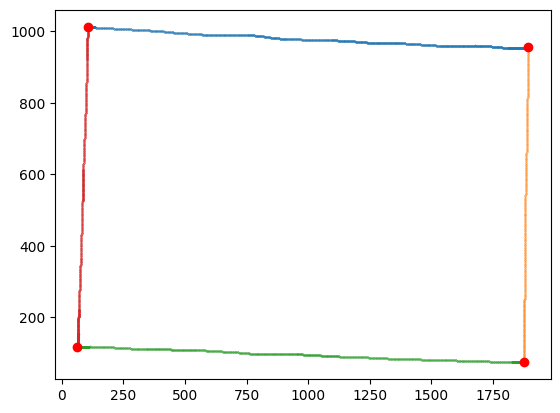

In [20]:
shape = ShapeTester(data[2], ranges[2], 2.9)
# a, b, c = shape.compute_square()

sorter = PointSorter(data[0])
b, c = sorter.reorder_points_and_get_borders()
sorter.visualize_data(b, c)

In [ ]:
# def get_gradients(data):
#     grads = []
#     for i in range(1, len(data)):
#         num = (data[i][1] - data[i-1][1])
#         den = (data[i][0] - data[i-1][0])
#         grad = num if den == 0 else num / den
#         grads.append(grad)
#     return grads

# grads = get_gradients(data)
# grads.append(grads[-1])

# lim = int(len(data) * 1.0)
# xs = [d[0] for d in data]
# ys = [d[1] for d in data]

# grad_change = stat.stdev(grads)

# colors = []
# col = random.random(), random.random(), random.random()

# for i in range(len(grads)):
#     if i > 0:
#         if abs(grads[i] - grads[i-1]) > grad_change:
#             col = random.random(), random.random(), random.random()        
#     colors.append(col)
    
# plt.scatter(xs[:lim], ys[:lim], c=colors[:lim])

# for d, n in zip(data, ["betademo", "arrowspa", "seagrit", "shamrock"]):
#     print(n)
#     print("Old", len(d))
#     print("New", len(remove_repeated(d)))
#     print()